In [ ]:
pip install sympy

: 

In [1]:
import numpy as np
from numpy import transpose, real, sqrt, sin, cos, linalg, cosh, sinh
import scipy
import matplotlib.pyplot as plt
from itertools import combinations
from scipy import optimize
from scipy.optimize import minimize
import time
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from pprint import pprint
from scipy.linalg import block_diag
import os

def beep():
    os.system("afplay /System/Library/Sounds/Ping.aiff")


In [2]:
#FIXED PARAMETERS

ordering= 'xxpp'  #choose either xxpp or xpxp (so far only works for xxpp)


In [3]:
'''Auxiliary functions for perfect matchings'''

def perfect_matchings(num_ladder_operators):
    '''
    Finds all existing perfect matchings in a list of an even number of nodes
    referred to the even number of ladder operators indices applied to a Gaussian state.

    :param num_ladder_operators: EVEN number of ladder operators
    :return: List of lists containing all possible perfect matchings of the operators
    '''
    perf_matchings = []
    find_perf_match([i for i in range(num_ladder_operators)], [], perf_matchings)
    return perf_matchings

def find_perf_match(index_list, current_combination, perf_matchings):
    '''
    AUXILIARY RECUSRIVE FUNCTION OF perfect_matchings(num_ladder_operators) that creates
    all existing perfect matchings given an index list and stores them in
    perf_matchings parameter

    :param index_list: Number of existing indices (or nodes in a complete graph)
    :param current_combination: The perfect matching combination being filled at the moment
    :param perf_matchings: List of lists that will store all perfect matchings at the end of the recursive calls
    '''
    if len(index_list) > 0:
        v1 = index_list.pop(0)
        current_combination.append(v1)
        for i in range(len(index_list)):
            new_combination = current_combination.copy()
            new_idx_list = index_list.copy()
            v2 = new_idx_list.pop(i)
            new_combination.append(v2)
            find_perf_match(new_idx_list, new_combination, perf_matchings)
    else:
        perf_matchings.append(current_combination)

perfect_matchings(12)
#print(len(perfect_matchings(12)))

def p_matchings(elements):  #input is an array/list of numbers #output is a reshaped array that we can iterate through after
    x=len(elements)
    y=len(perfect_matchings(x))
    return np.reshape(perfect_matchings(x),(1,y,int(x/2),2)).tolist()[0]

p_matchings([0,1,2,3,4,5,6,7,8,9,10,11])
print(len(p_matchings([0,1,2,3,4,5,6,7,8,9,10,11])))

10395


In [4]:
#COVARIANCE MATRIX BUILDING
#function that builds squeezing matrix D
def sq(z):
  N=len(z)
  if ordering == 'xpxp':
    d_vector=[]
    for item in z:
        d_vector+=[item, 1/item]
    D=d_vector*np.eye(2*N)

    #convention x1,x2,p1,p2
  elif ordering == 'xxpp':
    d_vector=[item for item in z]
    for item in z:
        d_vector+=[1/item]
    D=d_vector*np.eye(2*N)

  return D



#function that builds an orthogonal matrix out of a random one
def Orth(params):
    N=int(np.sqrt(len(params)))
    M=np.resize(params,(N,N))
    H= M + transpose(np.conjugate(M))
    U=scipy.linalg.expm(1j*H)
    unitary_check=(np.round(U @ transpose(np.conjugate(U)),4)==np.eye(N)).all()
    #print(np.round(U @ transpose(np.conjugate(U)),4))
    #print('U unitary:', unitary_check)

    #first build matrix O
    Ubar= (1/sqrt(2))*np.block([[np.eye(N), 1j*np.eye(N)],[np.eye(N), -1j*np.eye(N)] ])

    V= np.block([[np.conjugate(U),np.zeros((N,N))],[np.zeros((N,N)), U]])
    #print('V=', np.round(V,3))

    #print('V * Ubar=', np.round(V @ Ubar,3))

    O=transpose(np.conjugate(Ubar)) @ (V @ Ubar)
    orth= O @ transpose(O)
    orth_check=(np.round(orth,2)==np.eye(2*N)).all()

    #print('O is orthogonal:', orth_check)
    return O

#function that builds covariance matrix
#z is the squeezing (it has to fulfill certain properties)
#phi is a vector of dephasing angles for each  mode
#x is the beamsplitter angle
#modesbs is a vector of the form: [modei, modej] (modei and modej are the modes we entangle with the beamsplitter)
#params1 is the vector of passive optics O1
#params2 is the vector of passive optics O2

#in order to build the most general covariance matrix we can let all parameters free ¿except for the squeezing? (it has constraints)

def V_tms(z,x, phi, params): #no params2 since i have checked that the correct definition is with O and O transpose (same orthogonal matrix)
    #now x is going to be a list of lenght(N(N-1)/2) of angles for the beamsplitter between all possible pairs of modes
    N=len(z)
    if ordering == 'xpxp': #this only works for N=2 so far
      B=np.array([[cos(x),0,sin(x),0],[0,cos(x),0,sin(x)],[-sin(x),0,cos(x),0],[0,-sin(x),0,cos(x)]])
      P1=np.array([[cos(phi1),sin(phi1)], [-sin(phi1), cos(phi1)]])
      P2=np.array([[cos(phi2),sin(phi2)], [-sin(phi2), cos(phi2)]])
      P= np.block([[P1,np.zeros((N,N))],[np.zeros((N,N)), P2]])
    elif ordering == 'xxpp':
      #beamsplitter
      B_total=np.eye(2*N)
      #print('x:',cos(x),sin(x))
      index=0
      for i in range(N):
          for j in range(i+1,N):
              B=np.eye(2*N)
              B[i,i]=B[j,j]=B[N+i,N+i]=B[N+j,N+j]= cos(x[index])
              B[i,j]=B[N+i,N+j]= sin(x[index])
              B[j,i]=B[N+j,N+i]= -sin(x[index])
              index+=1
              B_total=B_total@B
      #print('B',np.round(B_total,2))
      #dephasing
      P= np.zeros((2*N, 2*N))
      for i in range(N):
        P[i,i]=P[i+N,i+N]= cos(phi[i])
        P[i,i+N]=sin(phi[i])
        P[i+N,i]=-sin(phi[i])
      #print('P',P)
    S=sq(z)
    #print('S',S)
    if params is not None:
      O1= Orth(params)
      result= P @ B_total @ O1 @ S @ transpose(O1) @ transpose(B_total) @ transpose(P)
    else:
      result= P @ B_total @ S @ transpose(B_total) @ transpose(P)
    return result

#the definition of this identities is
def id1(sigma,l,k): #function to compute Tr(a^dag_l a^dag_k rho)
    N= len(sigma)//2
    if ordering == 'xpxp':
      sigma=convention_switch(sigma,'xpxp','number')
    return (1/4)*(sigma[l-1][k-1]-sigma[l+N-1][k+N-1]-1j*(sigma[l-1][k+N-1]+sigma[l+N-1][k-1]))

def id2(sigma,l,k): #function to compute Tr(a_l a_k rho)
    N= len(sigma)//2
    if ordering == 'xpxp':
      sigma=convention_switch(sigma,'xpxp','number')

    return np.conjugate(id1(sigma,l,k))

def id3(sigma,l,k): #function to compute Tr(a^dag_l a_k rho)
    N= len(sigma)//2
    if ordering == 'xpxp':
      sigma=convention_switch(sigma,'xpxp','number')
    delta=0
    if l==k:
        delta+=1
    return (1/4)*(sigma[l-1][k-1]+sigma[l+N-1][k+N-1]+1j*(sigma[l-1][k+N-1]-sigma[l+N-1][k-1])-2*delta)

def id4(sigma,l,k):  #function to compute Tr(a^_l a^dag_k rho)
    N= len(sigma)//2
    if ordering == 'xpxp':
      sigma=convention_switch(sigma,'xpxp','number')
    delta2=0
    if l==k:
        delta2+=1
    return id3(sigma,l,k)+delta2

#function to compute traces (defined in the paper)
def trace_func(sigma,l,k,case):
    if case==1:
        return id1(sigma,l,k)
    elif case==2:
        return id2(sigma,l,k)
    elif case==3:
        return id3(sigma,l,k)
    elif case==4:
        return id4(sigma,l,k)

def expectationvalue(covmat,operatorlist,modeslist):
    indices=[i for i in range(len(operatorlist))]
    trace=0
    #print('Perfect matchings',perfect_matchings(indices))
    for matching in p_matchings(indices):
        #print('matching:',matching)
        factor=1
        for pair in matching:
            #print(pair)
            l,k= modeslist[pair[0]],modeslist[pair[1]]
            #print('l,k:',l,k)
            if operatorlist[pair[0]]=='adag' and operatorlist[pair[1]]=='adag':
                case=1
            elif operatorlist[pair[0]]=='a' and operatorlist[pair[1]]=='a':
                case=2
            elif operatorlist[pair[0]]=='adag' and operatorlist[pair[1]]=='a':
                case=3
            elif operatorlist[pair[0]]=='a' and operatorlist[pair[1]]=='adag':
                case=4
            #print('case',case)
            factor*=trace_func(covmat,l,k,case)
        trace+=factor
    return trace

N=3
print(np.round(V_tms(2*np.pi*np.random.rand(N),2*np.pi*np.random.rand((N*(N-1))//2),2*np.pi*np.random.rand(N), params=2*np.pi*np.random.rand(N**2)),2))



[[ 0.69+0.j  0.09+0.j  0.24+0.j -0.97+0.j  0.17+0.j  0.27+0.j]
 [ 0.09+0.j  0.94+0.j  0.  +0.j  0.22+0.j -0.85+0.j -0.01+0.j]
 [ 0.24+0.j  0.  +0.j  1.24+0.j -0.18+0.j  0.05+0.j  0.96+0.j]
 [-0.97+0.j  0.22+0.j -0.18+0.j  3.07+0.j -0.71+0.j -0.58+0.j]
 [ 0.17+0.j -0.85+0.j  0.05+0.j -0.71+0.j  1.95+0.j  0.11+0.j]
 [ 0.27+0.j -0.01+0.j  0.96+0.j -0.58+0.j  0.11+0.j  1.62+0.j]]


In [10]:
#Analytical (symbolic) covariance matrix expression
from sympy import symbols, cos, sin, Matrix, simplify

def V_tms_sym(z,x, phi, params): #no params2 since i have checked that the correct definition is with O and O transpose (same orthogonal matrix)
    #now x is going to be a list of lenght(N(N-1)/2) of angles for the beamsplitter between all possible pairs of modes
    N=len(z)
    if ordering == 'xpxp': #this only works for N=2 so far
      B=np.array([[cos(x),0,sin(x),0],[0,cos(x),0,sin(x)],[-sin(x),0,cos(x),0],[0,-sin(x),0,cos(x)]])
      P1=np.array([[cos(phi1),sin(phi1)], [-sin(phi1), cos(phi1)]])
      P2=np.array([[cos(phi2),sin(phi2)], [-sin(phi2), cos(phi2)]])
      P= np.block([[P1,np.zeros((N,N))],[np.zeros((N,N)), P2]])
    elif ordering == 'xxpp':
      #beamsplitter
      B_total=Matrix.eye(2*N)
      #print('x:',cos(x),sin(x))
      index=0
      for i in range(N):
          for j in range(i+1,N):
              B=Matrix.eye(2*N)
              B[i,i]=B[j,j]=B[N+i,N+i]=B[N+j,N+j]= cos(x[index])
              B[i,j]=B[N+i,N+j]= sin(x[index])
              B[j,i]=B[N+j,N+i]= -sin(x[index])
              index+=1
              B_total=B_total@B
      #print('B',np.round(B_total,2))
      #dephasing
      P= Matrix.eye(2*N)
      for i in range(N):
        P[i,i]=P[i+N,i+N]= cos(phi[i])
        P[i,i+N]=sin(phi[i])
        P[i+N,i]=-sin(phi[i])
      #print('P',P)
    S=sq(z)
    #print('S',S)
    if params is not None:
      O1= Orth(params)
      result= B_total @ O1 @ S @ transpose(O1) @ transpose(B_total) 
    else:
      result= B_total @ S @ transpose(B_total) 
    return simplify(result)


#the definition of this identities is
def id1_sym(sigma,l,k): #function to compute Tr(a^dag_l a^dag_k rho)
    if ordering == 'xpxp':
      sigma=convention_switch(sigma,'xpxp','number')
    return (1/4)*sigma[l-1,k-1]-sigma[l+N-1,k+N-1]-1j*(sigma[l-1,k+N-1]+sigma[l+N-1,k-1])

def id2_sym(sigma,l,k): #function to compute Tr(a_l a_k rho)
    if ordering == 'xpxp':
      sigma=convention_switch(sigma,'xpxp','number')
    return np.conjugate(id1_sym(sigma,l,k))

def id3_sym(sigma,l,k): #function to compute Tr(a^dag_l a_k rho)
    if ordering == 'xpxp':
      sigma=convention_switch(sigma,'xpxp','number')
    delta=0
    if l==k:
        delta+=1
    return (1/4)*sigma[l-1,k-1]+sigma[l+N-1,k+N-1]+1j*(sigma[l-1,k+N-1]-sigma[l+N-1,k-1])-2*delta


def id4_sym(sigma,l,k):  #function to compute Tr(a^_l a^dag_k rho)
    if ordering == 'xpxp':
      sigma=convention_switch(sigma,'xpxp','number')
    delta2=0
    if l==k:
        delta2+=1
    return id3_sym(sigma,l,k)+delta2

#function to compute traces (defined in the paper)
def trace_func_sym(sigma,l,k,case):
    if case==1:
        return id1_sym(sigma,l,k)
    elif case==2:
        return id2_sym(sigma,l,k)
    elif case==3:
        return id3_sym(sigma,l,k)
    elif case==4:
        return id4_sym(sigma,l,k)

def expectationvalue_sym(covmat,operatorlist,modeslist):
    indices=[i for i in range(len(operatorlist))]
    trace=0
    #print('Perfect matchings',perfect_matchings(indices))
    for matching in p_matchings(indices):
        #print('matching:',matching)
        factor=1
        for pair in matching:
            #print(pair)
            l,k= modeslist[pair[0]],modeslist[pair[1]]
            #print('l,k:',l,k)
            if operatorlist[pair[0]]=='adag' and operatorlist[pair[1]]=='adag':
                case=1
            elif operatorlist[pair[0]]=='a' and operatorlist[pair[1]]=='a':
                case=2
            elif operatorlist[pair[0]]=='adag' and operatorlist[pair[1]]=='a':
                case=3
            elif operatorlist[pair[0]]=='a' and operatorlist[pair[1]]=='adag':
                case=4
            #print('case',case)
            factor*=trace_func_sym(covmat,l,k,case)
        trace+=factor
    return trace

N=2
z1,z2, x1, phi1, phi2 =symbols('z1,z2,x1,phi1,phi2',real=True)
z_values = [z1,z2]  #1:N+1
theta_values = [x1]  #N*(N-1)//2 +1
phi_values = [phi1,phi2] #1:N+1

mat=V_tms_sym(z_values,theta_values,phi_values, params=None)
pprint(mat)

#print(z_values, theta_values,phi_values)


Matrix([
[1.0*z1*cos(x1)**2 + 1.0*z2*sin(x1)**2,              0.5*(-z1 + z2)*sin(2*x1),                                     0,                                     0],
[             0.5*(-z1 + z2)*sin(2*x1), 1.0*z1*sin(x1)**2 + 1.0*z2*cos(x1)**2,                                     0,                                     0],
[                                    0,                                     0, 1.0*sin(x1)**2/z2 + 1.0*cos(x1)**2/z1,       0.5*(z1 - z2)*sin(2*x1)/(z1*z2)],
[                                    0,                                     0,       0.5*(z1 - z2)*sin(2*x1)/(z1*z2), 1.0*cos(x1)**2/z2 + 1.0*sin(x1)**2/z1]])


In [11]:
#GAUSSIAN STATE

#Expectation value of N
def expvalN(sigma): #input a 2N x 2N np.array of parameters for M
    N=len(sigma)//2
    #print('sigma',np.round(sigma,3))
    K=0
    for i in range(2*N):
        K+=sigma[i][i]
    #print('K=',K) #K is tr(sigma)

    #now let's calculate the tr(prod(a's)rho). The amount of ladder operators is twice the number of modes (2N)
    #the amount of destruction operators is N, and the amount of creation is also N
    sum=0
    for i in range(1,N+1):
      ops=['adag','a']
      modes=[i,i]
      sum+=expectationvalue(sigma,ops,modes)

    return sum/np.abs(K)


#Expectation value of N^2

def N2(sigma): #dispersion of number operator on gaussian state (rho0)
    #We now compute exp(N^2):
    N=len(sigma)//2
    K=0
    for i in range(2*N):
        K+=sigma[i][i]
    #print('K=',K) #K is tr(sigma)
    sum=0
    for i in range(1,N+1):
      ops= ['adag','a','adag','a']
      modes=[i,i,i,i]
      sum+=expectationvalue(sigma,ops,modes)
    for i in range(1,N+1):
      for j in range(i+1,N+1):
        ops= ['adag','a','adag','a']
        modes=[i,i,j,j]
        sum+=2*expectationvalue(sigma,ops,modes)
    return (1/K)*sum


def varianceN(sigma):
    return  np.sqrt(N2(sigma) - (expvalN(sigma))**2)

def SNR_gaussian(sigma):
  return expvalN(sigma)/varianceN(sigma)



print(expvalN(V_tms([0.5,2],[np.pi/4],phi=[np.pi/5,np.pi/3], params=None)))
print(N2(V_tms([0.5,2],[np.pi/4],[np.pi/5,np.pi/3], params=None)))
print(varianceN(V_tms([0.5,2],[np.pi/4],[np.pi/5,np.pi/3], params=None)))
print(SNR_gaussian(V_tms([0.5,2],[np.pi/4],[np.pi/5,np.pi/3], params=None)))

(0.05+5.551115123125783e-18j)
(0.125+9.71445146547012e-18j)
(0.35+1.3084771361653632e-17j)
(0.14285714285714288+1.0519605918459937e-17j)


In [12]:
#GAUSSIAN STATE (symbolic/analytical expression)
from sympy import sqrt

#Expectation value of N
def expvalN_sym(sigma): #input a 2N x 2N np.array of parameters for M
    #print('sigma',np.round(sigma,3))
    K=0
    for i in range(2*N):
        K+=sigma[i,i]
    #print('K=',K) #K is tr(sigma)

    #now let's calculate the tr(prod(a's)rho). The amount of ladder operators is twice the number of modes (2N)
    #the amount of destruction operators is N, and the amount of creation is also N
    sum=0
    for i in range(1,N+1):
      ops=['adag','a']
      modes=[i,i]
      sum+=expectationvalue_sym(sigma,ops,modes)

    return sum/np.abs(K)


#Expectation value of N^2

def N2_sym(sigma): #dispersion of number operator on gaussian state (rho0)
    #We now compute exp(N^2):
    K=0
    for i in range(2*N):
        K+=sigma[i,i]
    #print('K=',K) #K is tr(sigma)
    sum=0
    for i in range(1,N+1):
      ops= ['adag','a','adag','a']
      modes=[i,i,i,i]
      sum+=expectationvalue_sym(sigma,ops,modes)
    for i in range(1,N+1):
      for j in range(i+1,N+1):
        ops= ['adag','a','adag','a']
        modes=[i,i,j,j]
        sum+=2*expectationvalue_sym(sigma,ops,modes)
    return (1/K)*sum


def varianceN_sym(sigma):
    return  sqrt(N2_sym(sigma) - (expvalN_sym(sigma))**2)

def SNR_gaussian_sym(sigma):
  return expvalN_sym(sigma)/varianceN_sym(sigma)

covmat= V_tms_sym(z_values,theta_values,phi_values, params=None)

print('N=',expvalN_sym(covmat))
print('')
beep()
print('N2=',N2_sym(covmat))
beep()
print('')
print('deltaN=',varianceN_sym(covmat))
print('')
beep()
ratio= SNR_gaussian_sym(covmat)
print('ratio=',ratio)
print('')
beep()
diff_z1 = ratio.diff(z1)
print('diff z1=',diff_z1)
print('')
diff_z2 = ratio.diff(z2)
print('diff z2=',diff_z2)
print('')
diff_x1 = ratio.diff(x1)
print('diff x1=',diff_x1)
print('')
beep()



N= (0.25*z1*sin(x1)**2 + 0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 + 0.25*z2*cos(x1)**2 - 4 + 1.0*sin(x1)**2/z2 + 1.0*cos(x1)**2/z2 + 1.0*sin(x1)**2/z1 + 1.0*cos(x1)**2/z1)/Abs(1.0*z1*sin(x1)**2 + 1.0*z1*cos(x1)**2 + 1.0*z2*sin(x1)**2 + 1.0*z2*cos(x1)**2 + 1.0*sin(x1)**2/z2 + 1.0*cos(x1)**2/z2 + 1.0*sin(x1)**2/z1 + 1.0*cos(x1)**2/z1)

N2= (0.5*(0.25*(-z1 + z2)*sin(2*x1) - (z1 - z2)*sin(2*x1)/(z1*z2))**2 + 0.5*(0.25*(-z1 + z2)*sin(2*x1) + (z1 - z2)*sin(2*x1)/(z1*z2))**2 + (0.25*z1*sin(x1)**2 + 0.25*z2*cos(x1)**2 - 1.0*cos(x1)**2/z2 - 1.0*sin(x1)**2/z1)**2 + (0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 1.0*sin(x1)**2/z2 - 1.0*cos(x1)**2/z1)**2 + 4*(0.125*z1*sin(x1)**2 + 0.125*z2*cos(x1)**2 - 1 + 0.5*cos(x1)**2/z2 + 0.5*sin(x1)**2/z1)**2 + (0.25*z1*sin(x1)**2 + 0.25*z2*cos(x1)**2 - 2 + 1.0*cos(x1)**2/z2 + 1.0*sin(x1)**2/z1)*(0.25*z1*sin(x1)**2 + 0.25*z2*cos(x1)**2 - 1 + 1.0*cos(x1)**2/z2 + 1.0*sin(x1)**2/z1) + 2*(0.25*z1*sin(x1)**2 + 0.25*z2*cos(x1)**2 - 2 + 1.0*cos(x1)**2/z2 + 1.0*sin(x1)**2

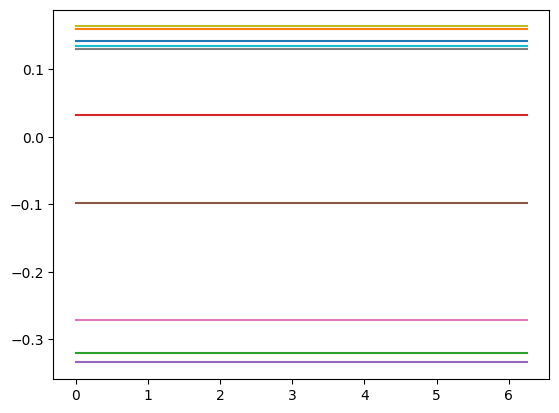

In [13]:
for i in range(10):
  x1_grid=np.arange(0,2*np.pi,0.05)
  z1_example=np.random.rand()
  z2_example=np.random.rand()
  f=[]
  for item in x1_grid:
    f+=[ratio.evalf(subs={z1:z1_example,z2:z2_example,x1:item})]
  plt.plot(x1_grid,f)
plt.show()

In [14]:
#NON-GAUSSIAN STATE

#fist calculate the normalization value (will need to divide by it in every expectation value)


def K_ng(sigma, nongaussian_ops):
    ops=['rho']
    modes=['rho']
    for item in nongaussian_ops:
      if item<0: #subtraction
        ops=['a']+ops+['adag']
      if item>0: #addition
        ops=['adag']+ops+['a']
      modes=[np.abs(item)]+ modes+[np.abs(item)]
    cut = ops.index('rho')
    ops= ops[cut+1:]+ops[:cut]
    modes= modes[cut+1:]+modes[:cut]
    #print(ops)
    #print(modes)
    return expectationvalue(sigma,ops,modes)



#expectation value of N for the non-gaussian state
def expvalN_ng(sigma,nongaussian_ops):
    N= len(sigma)//2
    #construct the trace we want to calculate ((adag, a) per mode + non-gaussian cov matrix)
    sum=0
    for i in range(1,N+1):
      ops=['rho']
      modes=['rho']
      for item in nongaussian_ops:
        if item<0: #subtraction
          ops=['a']+ops+['adag']
        if item>0: #addition
          ops=['adag']+ops+['a']
        modes=[np.abs(item)]+ modes+[np.abs(item)]
      ops=['adag','a']+ops
      modes=[i,i]+modes
      cut = ops.index('rho')
      ops= ops[cut+1:]+ops[:cut]
      modes= modes[cut+1:]+modes[:cut]
      #print(ops)
      #print(modes)
      sum+=expectationvalue(sigma,ops,modes)
    return (1/K_ng(sigma,nongaussian_ops))*sum



#expectation value of N^2 for the non-gaussian state
def N2_ng(sigma,nongaussian_ops):
    N= len(sigma)//2
    sum=0
    for i in range(1,N+1):
      for j in range(1,N+1):
        ops=['rho']
        modes=['rho']
        for item in nongaussian_ops:
          if item<0: #subtraction
            ops=['a']+ops+['adag']
          if item>0: #addition
            ops=['adag']+ops+['a']
          modes=[np.abs(item)]+ modes+[np.abs(item)]
        ops=['adag','a','adag','a']+ops
        modes=[i,i,j,j]+modes
        cut = ops.index('rho')
        ops= ops[cut+1:]+ops[:cut]
        modes= modes[cut+1:]+modes[:cut]
        #print(ops)
        #print(modes)
        sum+=expectationvalue(sigma,ops,modes)
    return (1/K_ng(sigma,nongaussian_ops))*sum

def varianceN_ng(sigma,nongaussian_ops):
    return  np.sqrt(N2_ng(sigma,nongaussian_ops) - (expvalN_ng(sigma,nongaussian_ops))**2)

def SNR_ng(sigma,nongaussian_ops):
  return expvalN_ng(sigma,nongaussian_ops)/varianceN_ng(sigma,nongaussian_ops)

nongaussian_ops=[1,1,2]
print(K_ng(V_tms([0.5,2],[np.pi/4]+[0]*(((N-1)*N)//2-1),[np.pi/5,np.pi/3], params=None),nongaussian_ops))
print(expvalN_ng(V_tms([0.5,2],[np.pi/4]+[0]*(((N-1)*N)//2-1),[np.pi/5,np.pi/3], params=None),nongaussian_ops))
print(N2_ng(V_tms([0.5,2],[np.pi/4]+[0]*(((N-1)*N)//2-1),[np.pi/5,np.pi/3], params=None),nongaussian_ops))
print(varianceN_ng(V_tms([0.5,2],[np.pi/4]+[0]*(((N-1)*N)//2-1),[np.pi/5,np.pi/3], params=None),nongaussian_ops))
print(SNR_ng(V_tms([0.5,2],[np.pi/4]+[0]*(((N-1)*N)//2-1),[np.pi/5,np.pi/3], params=None),nongaussian_ops))


(3.4804687500000004-6.938893903907228e-17j)
(4.363636363636363+2.852585584901846e-17j)
(21.886363636363633+3.2659598704455003e-16j)
(1.68672502866177+2.3015921964737547e-17j)
(2.5870466670542185-1.8389131501561146e-17j)


In [15]:
#Non gaussian state SYMBOLIC expectation values
def K_ng_sym(sigma, nongaussian_ops):
    ops=['rho']
    modes=['rho']
    for item in nongaussian_ops:
      if item<0: #subtraction
        ops=['a']+ops+['adag']
      if item>0: #addition
        ops=['adag']+ops+['a']
      modes=[np.abs(item)]+ modes+[np.abs(item)]
    cut = ops.index('rho')
    ops= ops[cut+1:]+ops[:cut]
    modes= modes[cut+1:]+modes[:cut]
    #print(ops)
    #print(modes)
    return expectationvalue_sym(sigma,ops,modes)



#expectation value of N for the non-gaussian state
def expvalN_ng_sym(sigma,nongaussian_ops):
    #construct the trace we want to calculate ((adag, a) per mode + non-gaussian cov matrix)
    sum=0
    for i in range(1,N+1):
      ops=['rho']
      modes=['rho']
      for item in nongaussian_ops:
        if item<0: #subtraction
          ops=['a']+ops+['adag']
        if item>0: #addition
          ops=['adag']+ops+['a']
        modes=[np.abs(item)]+ modes+[np.abs(item)]
      ops=['adag','a']+ops
      modes=[i,i]+modes
      cut = ops.index('rho')
      ops= ops[cut+1:]+ops[:cut]
      modes= modes[cut+1:]+modes[:cut]
      #print(ops)
      #print(modes)
      sum+=expectationvalue_sym(sigma,ops,modes)
    return (1/K_ng_sym(sigma,nongaussian_ops))*sum



#expectation value of N^2 for the non-gaussian state
def N2_ng_sym(sigma,nongaussian_ops):
    sum=0
    for i in range(1,N+1):
      for j in range(1,N+1):
        ops=['rho']
        modes=['rho']
        for item in nongaussian_ops:
          if item<0: #subtraction
            ops=['a']+ops+['adag']
          if item>0: #addition
            ops=['adag']+ops+['a']
          modes=[np.abs(item)]+ modes+[np.abs(item)]
        ops=['adag','a','adag','a']+ops
        modes=[i,i,j,j]+modes
        cut = ops.index('rho')
        ops= ops[cut+1:]+ops[:cut]
        modes= modes[cut+1:]+modes[:cut]
        #print(ops)
        #print(modes)
        sum+=expectationvalue_sym(sigma,ops,modes)
    return (1/K_ng_sym(sigma,nongaussian_ops))*sum

def varianceN_ng_sym(sigma,nongaussian_ops):
    return  sqrt(N2_ng_sym(sigma,nongaussian_ops) - (expvalN_ng_sym(sigma,nongaussian_ops))**2)

def SNR_ng_sym(sigma,nongaussian_ops):
  return expvalN_ng_sym(sigma,nongaussian_ops)/varianceN_ng_sym(sigma,nongaussian_ops)


print('N=',expvalN_ng_sym(covmat,[1]))
print('')
print('N2=',N2_ng_sym(covmat,[1]))
print('')
print('deltaN=',varianceN_ng_sym(covmat,[1]))
print('')
ratio_ng= SNR_ng_sym(covmat,[1])
print('SNR=',ratio_ng)
print('')
diff_z1 = ratio_ng.diff(z1)
print('diff z1=',diff_z1)
print('')
diff_z2 = ratio_ng.diff(z2)
print('diff z2=',diff_z2)
print('')
diff_x1 = ratio_ng.diff(x1)
print('diff x1=',diff_x1)



N= (0.25*(0.25*(-z1 + z2)*sin(2*x1) - (z1 - z2)*sin(2*x1)/(z1*z2))**2 + 0.25*(0.25*(-z1 + z2)*sin(2*x1) + (z1 - z2)*sin(2*x1)/(z1*z2))**2 + (0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 1.0*sin(x1)**2/z2 - 1.0*cos(x1)**2/z1)**2 + (0.25*z1*sin(x1)**2 + 0.25*z2*cos(x1)**2 - 2 + 1.0*cos(x1)**2/z2 + 1.0*sin(x1)**2/z1)*(0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 1 + 1.0*sin(x1)**2/z2 + 1.0*cos(x1)**2/z1) + (0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 2 + 1.0*sin(x1)**2/z2 + 1.0*cos(x1)**2/z1)*(0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 1 + 1.0*sin(x1)**2/z2 + 1.0*cos(x1)**2/z1) + (0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 1 + 1.0*sin(x1)**2/z2 + 1.0*cos(x1)**2/z1)**2)/(0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 1 + 1.0*sin(x1)**2/z2 + 1.0*cos(x1)**2/z1)

N2= (4*(0.125*(-z1 + z2)*sin(2*x1) - 0.5*(z1 - z2)*sin(2*x1)/(z1*z2))*(0.125*(-z1 + z2)*sin(2*x1) + 0.5*(z1 - z2)*sin(2*x1)/(z1*z2))*(0.25*z1*sin(x1)**2 + 0.25*z2*cos(x1)**2 - 1.0*cos(x1)**2/z2 - 1.0*sin(x1)**2/z1) + 8*(0.125*(-z1 + z2)*sin(2*x1) -

(0.25*(0.25*(-z1 + z2)*sin(2*x1) - (z1 - z2)*sin(2*x1)/(z1*z2))**2 + 0.25*(0.25*(-z1 + z2)*sin(2*x1) + (z1 - z2)*sin(2*x1)/(z1*z2))**2 + (0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 1.0*sin(x1)**2/z2 - 1.0*cos(x1)**2/z1)**2 + (0.25*z1*sin(x1)**2 + 0.25*z2*cos(x1)**2 - 2 + 1.0*cos(x1)**2/z2 + 1.0*sin(x1)**2/z1)*(0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 1 + 1.0*sin(x1)**2/z2 + 1.0*cos(x1)**2/z1) + (0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 2 + 1.0*sin(x1)**2/z2 + 1.0*cos(x1)**2/z1)*(0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 1 + 1.0*sin(x1)**2/z2 + 1.0*cos(x1)**2/z1) + (0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 1 + 1.0*sin(x1)**2/z2 + 1.0*cos(x1)**2/z1)**2)/(sqrt((4*(0.125*(-z1 + z2)*sin(2*x1) - 0.5*(z1 - z2)*sin(2*x1)/(z1*z2))*(0.125*(-z1 + z2)*sin(2*x1) + 0.5*(z1 - z2)*sin(2*x1)/(z1*z2))*(0.25*z1*sin(x1)**2 + 0.25*z2*cos(x1)**2 - 1.0*cos(x1)**2/z2 - 1.0*sin(x1)**2/z1) + 8*(0.125*(-z1 + z2)*sin(2*x1) - 0.5*(z1 - z2)*sin(2*x1)/(z1*z2))*(0.125*(-z1 + z2)*sin(2*x1) + 0.5*(z1 - z2)*sin(2*x1)/

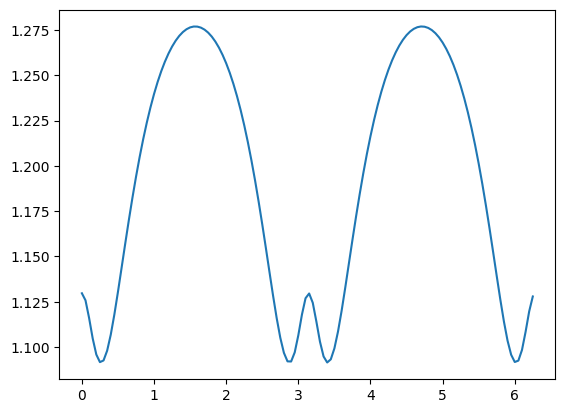

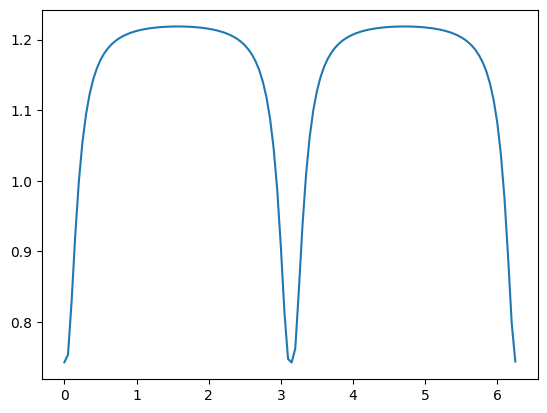

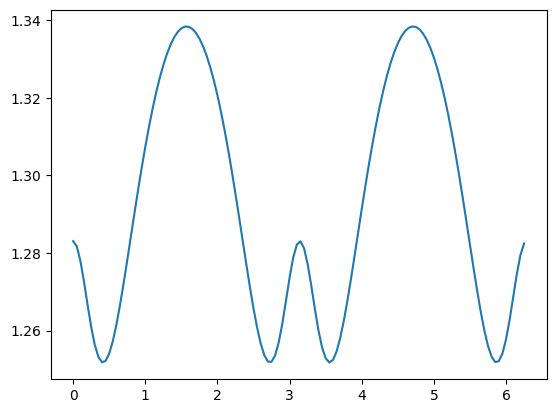

TypeError: Cannot convert complex to float

In [16]:

print(ratio_ng)
for i in range(7):
  x1_grid=np.arange(0,2*np.pi,0.05)
  z1_example=np.random.rand()
  z2_example=np.random.rand()
  f=[]
  for i in range(len(x1_grid)):
    f+=[float(ratio_ng.evalf(subs={z1:z1_example,z2:z2_example,x1:x1_grid[i]}))]
  plt.plot(x1_grid,f)
  plt.show()

(0.25*(0.25*(-z1 + z2)*sin(2*x1) - (z1 - z2)*sin(2*x1)/(z1*z2))**2 + 0.25*(0.25*(-z1 + z2)*sin(2*x1) + (z1 - z2)*sin(2*x1)/(z1*z2))**2 + (0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 1.0*sin(x1)**2/z2 - 1.0*cos(x1)**2/z1)**2 + (0.25*z1*sin(x1)**2 + 0.25*z2*cos(x1)**2 - 2 + 1.0*cos(x1)**2/z2 + 1.0*sin(x1)**2/z1)*(0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 2 + 1.0*sin(x1)**2/z2 + 1.0*cos(x1)**2/z1) + 8*(0.125*z1*cos(x1)**2 + 0.125*z2*sin(x1)**2 - 1 + 0.5*sin(x1)**2/z2 + 0.5*cos(x1)**2/z1)**2)/(sqrt((4*(0.125*(-z1 + z2)*sin(2*x1) - 0.5*(z1 - z2)*sin(2*x1)/(z1*z2))*(0.125*(-z1 + z2)*sin(2*x1) + 0.5*(z1 - z2)*sin(2*x1)/(z1*z2))*(0.25*z1*sin(x1)**2 + 0.25*z2*cos(x1)**2 - 1.0*cos(x1)**2/z2 - 1.0*sin(x1)**2/z1) + 8*(0.125*(-z1 + z2)*sin(2*x1) - 0.5*(z1 - z2)*sin(2*x1)/(z1*z2))*(0.125*(-z1 + z2)*sin(2*x1) + 0.5*(z1 - z2)*sin(2*x1)/(z1*z2))*(0.25*z1*cos(x1)**2 + 0.25*z2*sin(x1)**2 - 1.0*sin(x1)**2/z2 - 1.0*cos(x1)**2/z1) + 0.25*(0.25*(-z1 + z2)*sin(2*x1) - (z1 - z2)*sin(2*x1)/(z1*z2))**2*(0.25*z1*si

TypeError: Cannot convert complex to float

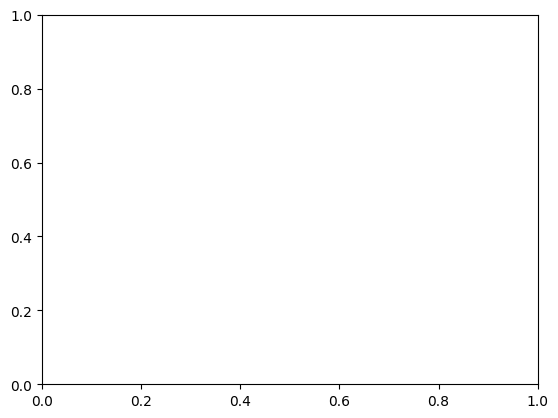

In [17]:
ratio_ng= SNR_ng_sym(covmat,[-1])

print(ratio_ng)
for i in range(7):
  x1_grid=np.arange(0,2*np.pi,0.05)
  z1_example=np.random.rand()
  z2_example=np.random.rand()
  print(z1_example,z2_example)
  f=[]
  for i in range(len(x1_grid)):
    f+=[ratio_ng.evalf(subs={z1:z1_example,z2:z2_example,x1:x1_grid[i]})]
  plt.plot(x1_grid,f)
  plt.show()

In [ ]:
#CHANGE OF CONVENTION IN ORDERING OF THE CANONICAL VARIABLES

def convention_switch(sigma,ordering,format):
  # expresses the covariance matrix in the opposite convention
  array=sigma
  N=len(sigma)//2
  #print('input array:')
  #pprint(sigma)
  if format=='string':
    newarray= np.empty((2*N,2*N),dtype=object)
  else:
    newarray= np.zeros((2*N,2*N))
  if ordering=='xxpp':
    for k in range(N):
      newarray[:, 2*k] = array[:, k]
      newarray[:,2*k+1]= array[:, N+k]
    if format=='string':
      newarray2= np.empty((2*N,2*N),dtype=object)
    else:
      newarray2= np.zeros((2*N,2*N))
    for k in range(N):
      newarray2[2*k,:] = newarray[k,:]
      newarray2[2*k+1,:]= newarray[N+k,:]
    #print('swapped array:',newarray2)
    return newarray2
  elif ordering=='xpxp':
    for k in range(N):
        newarray[:, k] = array[:, 2*k]
        newarray[:, N+k] = array[:, 2*k+1]
    if format=='string':
      newarray2= np.empty((2*N,2*N),dtype=object)
    else:
      newarray2= np.zeros((2*N,2*N))
    for k in range(N):
        newarray2[k, :] = newarray[2*k, :]
        newarray2[N+k, :] = newarray[2*k+1, :]
    #print('swapped array:',newarray2)
    return newarray2

def create_test_matrix(N,ordering):
  def generate_labels(N,ordering):
    labels=[]
    if ordering=='xxpp':
      for i in range(N):
          labels.append(f"x{i+1}")
      for i in range(N):
          labels.append(f"p{i+1}")
      return labels
    if ordering=='xpxp':
      for i in range(N):
          labels.append(f"x{i+1}")
          labels.append(f"p{i+1}")
      return labels

  matrix = np.empty((2*N,2*N),dtype=object)
  labels= generate_labels(N,ordering)
  #print('label:',labels)

  for i in range(len(labels)):
      for j in range(len(labels)):
              matrix[i][j] = labels[i] + labels[j]  # Product of x's
  return matrix



sigma=create_test_matrix(4,'xxpp')
print(sigma)
sigma_1_swap=convention_switch(sigma,'xxpp','string')
print(sigma_1_swap)
sigma_2_swaps=convention_switch(sigma_1_swap,'xpxp','string')
print(sigma_2_swaps)

[['x1x1' 'x1x2' 'x1x3' 'x1x4' 'x1p1' 'x1p2' 'x1p3' 'x1p4']
 ['x2x1' 'x2x2' 'x2x3' 'x2x4' 'x2p1' 'x2p2' 'x2p3' 'x2p4']
 ['x3x1' 'x3x2' 'x3x3' 'x3x4' 'x3p1' 'x3p2' 'x3p3' 'x3p4']
 ['x4x1' 'x4x2' 'x4x3' 'x4x4' 'x4p1' 'x4p2' 'x4p3' 'x4p4']
 ['p1x1' 'p1x2' 'p1x3' 'p1x4' 'p1p1' 'p1p2' 'p1p3' 'p1p4']
 ['p2x1' 'p2x2' 'p2x3' 'p2x4' 'p2p1' 'p2p2' 'p2p3' 'p2p4']
 ['p3x1' 'p3x2' 'p3x3' 'p3x4' 'p3p1' 'p3p2' 'p3p3' 'p3p4']
 ['p4x1' 'p4x2' 'p4x3' 'p4x4' 'p4p1' 'p4p2' 'p4p3' 'p4p4']]
[['x1x1' 'x1p1' 'x1x2' 'x1p2' 'x1x3' 'x1p3' 'x1x4' 'x1p4']
 ['p1x1' 'p1p1' 'p1x2' 'p1p2' 'p1x3' 'p1p3' 'p1x4' 'p1p4']
 ['x2x1' 'x2p1' 'x2x2' 'x2p2' 'x2x3' 'x2p3' 'x2x4' 'x2p4']
 ['p2x1' 'p2p1' 'p2x2' 'p2p2' 'p2x3' 'p2p3' 'p2x4' 'p2p4']
 ['x3x1' 'x3p1' 'x3x2' 'x3p2' 'x3x3' 'x3p3' 'x3x4' 'x3p4']
 ['p3x1' 'p3p1' 'p3x2' 'p3p2' 'p3x3' 'p3p3' 'p3x4' 'p3p4']
 ['x4x1' 'x4p1' 'x4x2' 'x4p2' 'x4x3' 'x4p3' 'x4x4' 'x4p4']
 ['p4x1' 'p4p1' 'p4x2' 'p4p2' 'p4x3' 'p4p3' 'p4x4' 'p4p4']]
[['x1x1' 'x1x2' 'x1x3' 'x1x4' 'x1p1' 'x1p2' 'x1p3' 'x1

In [ ]:
# Gaussianity check function using Robertson-Schrodinger uncertainty relation


def gauss_check(sigma): #checks that the input covariance matrix corresponds to a gaussian state
  N= len(sigma)//2
  print('input sigma')
  pprint(np.round(sigma,1))
  if ordering=='xxpp':
    sigma=convention_switch(sigma,'xxpp','number')
  print('sigma after reordering')
  pprint(np.round(sigma,1))

  #define Omega matrix
  omega1=[[0,1],[-1,0]]
  Omega = np.zeros((2*N, 2*N))
  # Replace diagonal blocks with omega1
  for i in range(N):
      Omega[2*i:2*(i+1), 2*i:2*(i+1)] = omega1
  #check positivity of sigma + i*Omega:
  eigenvalues, eigenvectors= np.linalg.eig(sigma+1j*Omega)
  print('eigenvalues',np.round(eigenvalues,2))
  check=0
  for item in eigenvalues:
      if np.round(np.real(item),3) < 0:
        check= check
      else:
          check+=1
  if check==2*N:
    print('state is gaussian')
  if check!=2*N:
        print('Not gaussian state')

  return


N=3
gauss_check(V_tms(2*np.pi*np.random.rand(N),2*np.pi*np.random.rand((N*(N-1))//2),2*np.pi*np.random.rand(N), params=2*np.pi*np.random.rand(N**2)))

input sigma
array([[ 2.9+0.j,  1.1+0.j, -0.2+0.j,  1.3+0.j, -0.1+0.j, -1.2+0.j],
       [ 1.1+0.j,  4. +0.j,  0.7+0.j,  0. +0.j,  0.4+0.j,  1.1+0.j],
       [-0.2+0.j,  0.7+0.j,  2. +0.j, -1.5+0.j,  1.2+0.j, -0.8+0.j],
       [ 1.3+0.j,  0. +0.j, -1.5+0.j,  1.9+0.j, -1. +0.j,  0.3+0.j],
       [-0.1+0.j,  0.4+0.j,  1.2+0.j, -1. +0.j,  1. +0.j, -0.7+0.j],
       [-1.2+0.j,  1.1+0.j, -0.8+0.j,  0.3+0.j, -0.7+0.j,  2.6+0.j]])
sigma after reordering
array([[ 2.9,  1.3,  1.1, -0.1, -0.2, -1.2],
       [ 1.3,  1.9,  0. , -1. , -1.5,  0.3],
       [ 1.1,  0. ,  4. ,  0.4,  0.7,  1.1],
       [-0.1, -1. ,  0.4,  1. ,  1.2, -0.7],
       [-0.2, -1.5,  0.7,  1.2,  2. , -0.8],
       [-1.2,  0.3,  1.1, -0.7, -0.8,  2.6]])
eigenvalues [ 4.41+0.j  5.12-0.j  5.01+0.j  0.  -0.j -0.  +0.j -0.  +0.j]
state is gaussian


C:\Users\bpolo\AppData\Local\Temp\ipykernel_6784\3656539224.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  newarray[:, 2*k] = array[:, k]
C:\Users\bpolo\AppData\Local\Temp\ipykernel_6784\3656539224.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  newarray[:,2*k+1]= array[:, N+k]


In [ ]:
#NO CORRER ESTA CELDA ESTÁ TODAVÍA EN CONSTRUCCION

#Check for separability of the gaussian covariance matrix


def check(sigma,N):  #only for N=2
  #print('input sigma')
  #pprint(sigma)

  separability=True

  print('sigma after reordering')
  pprint(np.round(sigma,2))
  omega1=[[0,1],[-1,0]]
  block_vector=[]
  for i in range(N):
    block_vector+=[omega1]
  print('block_vector',block_vector)
  print(tuple(block_vector))
  Omega= block_diag(omega1,omega1)
  print('Omega',Omega)
  eigenvalues, eigenvectors= np.linalg.eig(sigma+1j*Omega)
  print('eigenvalues',eigenvalues)
  check=0
  for item in eigenvalues:
      if np.round(np.real(item),3) < 0:
        check= check
      else:
          check+=1
  if check==2*N:
    print('state is gaussian')
  if check!=2*N:
        print('Not gaussian state')
        return None
  if N!=2:
    print('Need to apply some other criterion for this value of N')
    return None
  sigmaA=np.array([[sigma[0][0],sigma[0][1]],[sigma[1][0],sigma[1][1]]])
  #print('sigmaA', sigmaA)
  sigmaB=np.array([[sigma[2][2],sigma[2][3]],[sigma[3][2],sigma[3][3]]])
  #print('sigmaB', sigmaB)
  sigmaAB=np.array([[sigma[0][2],sigma[0][3]],[sigma[1][2],sigma[1][3]]])
  #print('sigmaAB', sigmaAB)
  detA= np.linalg.det(sigmaA)
  detB= np.linalg.det(sigmaB)
  detAB= np.linalg.det(sigmaAB)
  determinant=np.linalg.det(sigma)
  det_hat= detA +detB -2*detAB
  nu= (det_hat - np.sqrt(det_hat**2-4*determinant))/2
  #print(nu)
  if nu <1:
    separability=False
  return nu

#print('Separability check for rho sep', check(rho_gaussian_sep))
#print('Separability check for rho ent', check(rho_gaussian_ent))

Initialization parameters: [1, 1] [0.090307542874564, 1.909692457125436] [0.7853981633974483] [0, 0] None
rho sep [[ 0.09  0.    0.    0.  ]
 [ 0.    1.91  0.    0.  ]
 [ 0.    0.   11.07  0.  ]
 [ 0.    0.    0.    0.52]]
rho ent [[ 1.    0.91  0.    0.  ]
 [ 0.91  1.    0.    0.  ]
 [ 0.    0.    5.8  -5.27]
 [ 0.    0.   -5.27  5.8 ]]
expvalN (0.1764539142632343+0j)
N2 (1.5499565950398442+0j)
variance N (1.2324044024511709+0j)
ratio N/delta(N) gaussian (0.1431785815697178+0j)
 
With beam splitter + phase shifter: (entanglement)
N (0.1764539142632343+0j)
N2 (1.5499565950398442+0j)
delta N (1.2324044024511709+0j)
ratio N/delta(N) gaussian (0.1431785815697178+0j)
 
Non gaussian
expvalN_ng (14.079201592161272+0j)
N2_ng (274.62112739269065+0j)
variance N_ng (8.740549749299191+0j)
ratio N/delta(N) non gaussian (1.6107913113005425+0j)
 
With beam splitter + phase shifter: (entanglement)
expvalN_ng (12.070243698281931+0j)
N2_ng (218.21157010169142+0j)
variance N_ng (8.515913759883713+0j)
ra

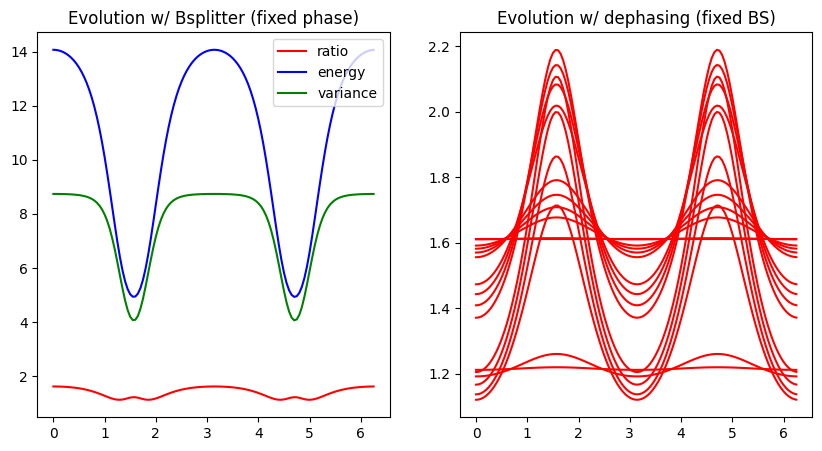

Initialization parameters: [1, 1] [0.304843888014925, 0.7158731924037925, 1.9792829195812824] [0.7853981633974483, 0.7853981633974483, 0.7853981633974483] [0, 0, 0] None
rho sep [[0.3  0.   0.   0.   0.   0.  ]
 [0.   0.72 0.   0.   0.   0.  ]
 [0.   0.   1.98 0.   0.   0.  ]
 [0.   0.   0.   3.28 0.   0.  ]
 [0.   0.   0.   0.   1.4  0.  ]
 [0.   0.   0.   0.   0.   0.51]]
rho ent [[ 1.53  0.26  0.68  0.    0.    0.  ]
 [ 0.26  0.64 -0.05  0.    0.    0.  ]
 [ 0.68 -0.05  0.83  0.    0.    0.  ]
 [ 0.    0.    0.    1.22 -0.58 -1.05]
 [ 0.    0.    0.   -0.58  1.85  0.6 ]
 [ 0.    0.    0.   -1.05  0.6   2.12]]
expvalN (0.06668186431867268+0j)
N2 (0.21191575867710402+0j)
variance N (0.45548796652391393+0j)
ratio N/delta(N) gaussian (0.14639654440831812+0j)
 
With beam splitter + phase shifter: (entanglement)
N (0.06668186431867268+0j)
N2 (0.21191575867710402+0j)
delta N (0.45548796652391393+0j)
ratio N/delta(N) gaussian (0.14639654440831812+0j)
 
Non gaussian
expvalN_ng (4.37938634649

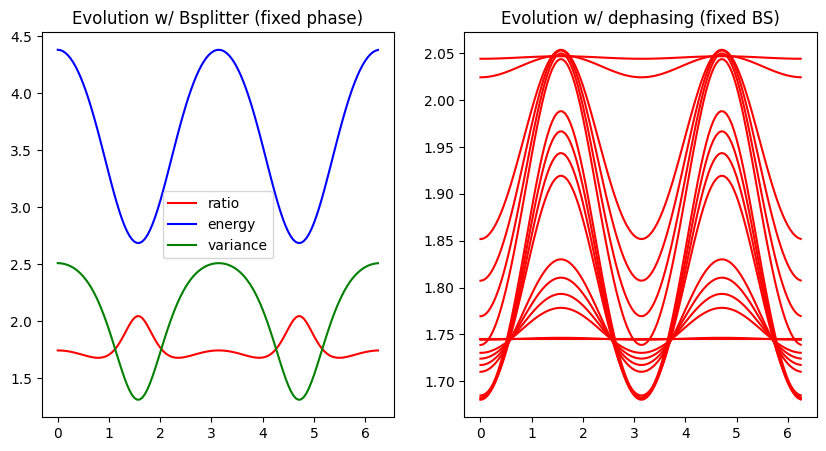

Initialization parameters: [1, 1] [0.0679489562392136, 0.8529109452808703, 0.7798196595870845, 2.2993204388928317] [0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483, 0.7853981633974483] [0, 0, 0, 0] None
rho sep [[ 0.07  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.85  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.78  0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    2.3   0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   14.72  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.17  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    1.28  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.43]]
rho ent [[ 1.8   0.54 -0.06  0.64  0.    0.    0.    0.  ]
 [ 0.54  0.93 -0.2  -0.02  0.    0.    0.    0.  ]
 [-0.06 -0.2   0.63 -0.33  0.    0.    0.    0.  ]
 [ 0.64 -0.02 -0.33  0.63  0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    2.34 -1.92 -2.27 -3.62]
 [ 0.    0.    0.    0.   -1.92  2.78  2.42  3.3 ]
 [ 0.    0.    

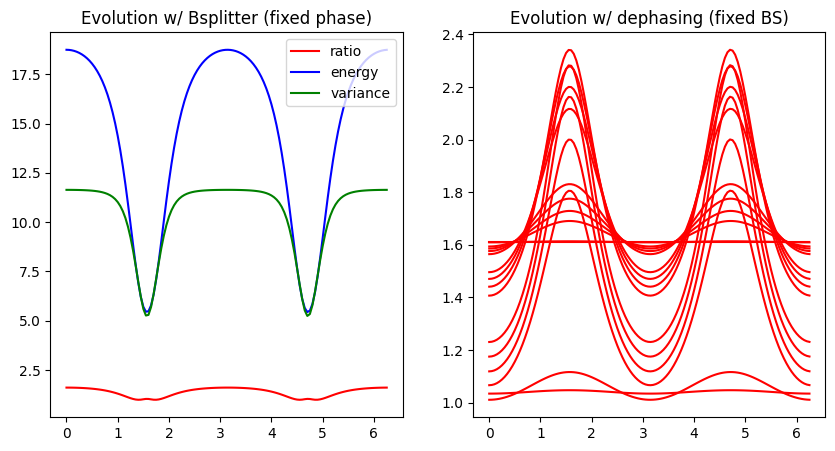

In [23]:
#check for V_tms
from mpl_toolkits.mplot3d import Axes3D

def results_and_plots(nongaussian_ops,z,theta,phi,params):
  N=len(z)
  print('Initialization parameters:',nongaussian_ops,z,theta,phi,params)
  rho_gaussian_sep= V_tms(z,[0]*((N**2-N)//2),phi,params)
  print('rho sep',np.round(rho_gaussian_sep,2))
  rho_gaussian_ent=V_tms(z,theta,phi,params)
  print('rho ent',np.round(V_tms(z,theta,phi,params),2))

  #GAUSSIAN QUANTITIES
  print('expvalN',expvalN(rho_gaussian_sep))
  print('N2', N2(rho_gaussian_sep))
  print('variance N',varianceN(rho_gaussian_sep))
  print('ratio N/delta(N) gaussian',expvalN(rho_gaussian_sep)/varianceN(rho_gaussian_sep))


  print(' ')
  print('With beam splitter + phase shifter: (entanglement)')
  print('N',expvalN(V_tms(z,theta,phi,params)))
  print('N2', N2(V_tms(z,theta,phi,params)))
  print('delta N',varianceN(V_tms(z,theta,phi,params)))
  print('ratio N/delta(N) gaussian',expvalN(V_tms(z,theta,phi,params))/varianceN(V_tms(z,theta,phi,params)))
  print(' ')

  #NON GAUSSIAN

  print('Non gaussian')
  print('expvalN_ng',expvalN_ng(rho_gaussian_sep,nongaussian_ops))
  print('N2_ng', N2_ng(rho_gaussian_sep,nongaussian_ops))
  print('variance N_ng',varianceN_ng(rho_gaussian_sep,nongaussian_ops))
  print('ratio N/delta(N) non gaussian',SNR_ng(rho_gaussian_sep,nongaussian_ops))

  print(' ')

  print('With beam splitter + phase shifter: (entanglement)')

  print('expvalN_ng',expvalN_ng(V_tms(z,theta,phi,params),nongaussian_ops))
  print('N2_ng', N2_ng(V_tms(z,theta,phi,params),nongaussian_ops))
  print('variance N_ng',varianceN_ng(V_tms(z,theta,phi,params),nongaussian_ops))
  print('ratio N/delta(N) non gaussian',SNR_ng(V_tms(z,theta,phi,params),nongaussian_ops))
  print(' ')

  # angle interval for beam splitter
  t = np.arange(0, 2*np.pi, 0.05)
  s = np.arange(0,2*np.pi, 0.05)
  w = np.arange(0,2*np.pi, 0.3)
  T,S = np.meshgrid(t,s)
  TS= np.stack([T,S])
  t_vec=np.arange(0,2*np.pi,0.005)

  #nongaussian case
  print(f"{nongaussian_ops}")
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  ax1.plot(t, [np.real(SNR_ng(V_tms(z,[w]+[0]*((N*(N-1))//2-1),phi,params),nongaussian_ops)) for w in t], 'r')
  ax1.set_title('Evolution w/ Bsplitter (fixed phase)')
  ax1.plot(t,[np.real(expvalN_ng(V_tms(z,[w]+[0]*((N*(N-1))//2-1),phi,params),nongaussian_ops)) for w in t],'b')
  ax1.plot(t,[np.real(varianceN_ng(V_tms(z,[w]+[0]*((N*(N-1))//2-1),phi,params),nongaussian_ops)) for w in t],'g')
  #ax1.plot(t_vec, [check(V_tms(z,t,modesBS,phi,params)) for t in t_vec],'-')

  ax1.legend(['ratio','energy', 'variance', 'PT eigenvalue nu_ '])
  #plt.show()

  t2_vec=np.arange(0,2*np.pi,0.4)
  for w in t2_vec:
    ax2.plot(s, [np.real(SNR_ng(V_tms(z,[w]+[0]*((N*(N-1))//2-1),[value]+[0]*(N-1),params),nongaussian_ops)) for value in s],'r')
  ax2.set_title('Evolution w/ dephasing (fixed BS)')
  plt.show()
  
  return

def main():
    for N in range(2,5):
      z_first=list(np.random.rand(N-1))
      z=z_first+[N-sum(z_first)]
      nongaussian_ops=[1,1]  #-n for photon subtraction on mode n, or +n if its photon addition on mode n
      theta=[np.pi/4]*((N*(N-1))//2)
      phi=[0]*N
      params=None #leave them at none if we want to start from vacuum and random if we want the most general cov matrix
      results_and_plots(nongaussian_ops,z,theta,phi,params)
      
    
    return

main()

In [ ]:
#3D PLOT: NO CORRER ESTA CELDA, TODAVÍA EN CONSTRUCCIÓN

def three_D_plot():
  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
  Z = np.abs(expvalN_ng(V_tms(z,T,modesBS,[0,0],params1,params2))/varianceN_ng(V_tms(z,T,modesBS,[0,0],params1,params2)))

  # Plot the surface.
  surf = ax.plot_surface(T, S, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

  # Customize the z axis.
  ax.set_zlim(-0.01, 2.01)
  ax.zaxis.set_major_locator(LinearLocator(10))
  # A StrMethodFormatter is used automatically
  ax.zaxis.set_major_formatter('{x:.02f}')
  plt.xlabel('angle x of BS')
  plt.ylabel('phi1')
  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=6)
  plt.title('Evolution of ratio as a function of the angle of dephasing phi1 and angle of beamsplitter')
  plt.show()
  return

Number of modes 2 Non-gaussian operations [-1]
{'type': 'eq', 'fun': <function optimization_1.<locals>.constraint_function at 0x7fbde5dc6a60>}
     fun: 0.5788862408775067
     jac: array([ 5.74573874e-04,  1.53226119e+00, -1.45286322e-06,  1.05120242e-03,
        1.05120242e-03,  1.48266554e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 230
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([1.99901000e+00, 1.00000000e-03, 3.30667493e+00, 6.14082855e+00,
       9.28378340e-01, 3.30680144e+00, 5.45024489e+00, 4.46492789e+00,
       2.55412221e+00, 2.30230146e+00, 2.06971939e+00, 1.91263156e+00,
       5.71234754e+00, 2.83795969e+00, 5.01845015e+00, 3.25909716e+00,
       3.76834635e+00, 3.20886167e-01])
Time taken to find maximum

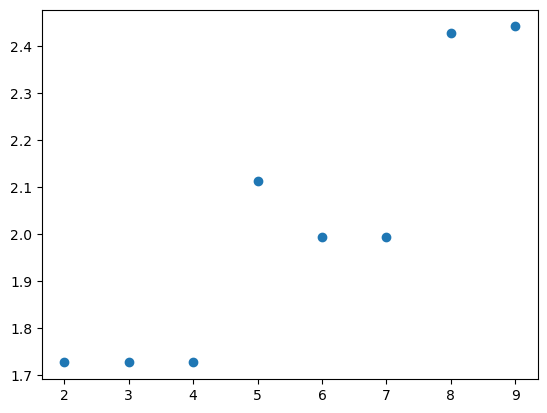

second optimization
Number of modes 2 Non-gaussian operations [-1]
     fun: 0.6966517678551848
     jac: array([ 9.15184259e-01,  4.01874632e-02,  2.04890966e-05, -1.98051333e-04,
       -1.98051333e-04, -2.04741955e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 268
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([0.1       , 1.9       , 5.17734727, 1.41015814, 0.95869095,
       5.17691985, 1.92508092, 1.28107235, 5.35749039, 4.34473203,
       2.02697921, 1.02509292, 2.60154377, 5.90668787, 5.03046459,
       4.17266974, 2.7574988 , 5.81266123])
Time taken to find maximum ratio 0.468966007232666
optimal ratio: 1.435437396618899
optimal squeezing: [0.1 1.9]

Number of modes 3 Non-gaussian operations [-1]
     fun: 0.20424227

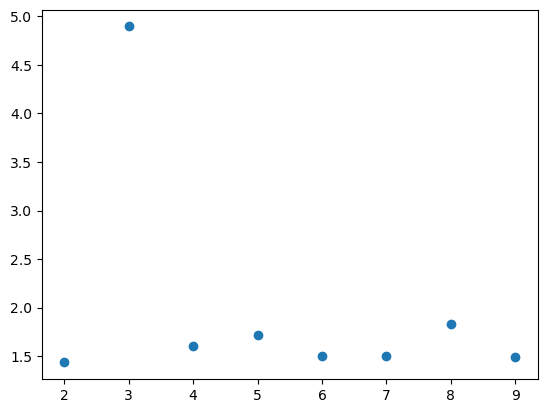

third optimization
Number of modes 2 Non-gaussian operations [-1]
      fun: 0.5887840577765509
 hess_inv: array([[ 16.14082772,   0.12941754,   0.12941754, -15.13876033,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.12941754,   0.96571398,  -0.03428602,  -0.12977885,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.12941754,  -0.03428602,   0.96571398,  -0.12977885,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [-15.13876033,  -0.12977885,  -0.12977885,  16.1366932 ,
          0.        ,   0.        ,   0.        ,   0.    

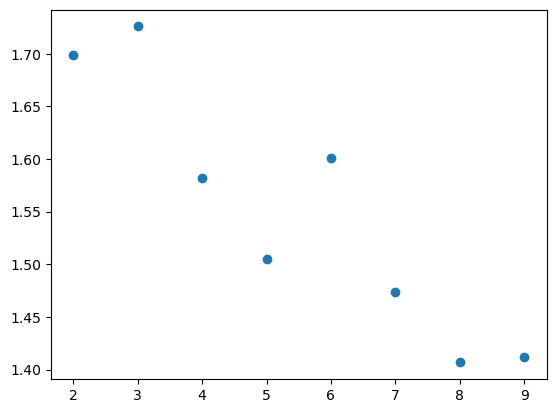

In [ ]:
#OPTIMIZATION

nongaussian_ops=[-1]  #-n for photon subtraction on mode n, or +n if its photon addition on mode n
n_max=10

#VERSION 1: optimization over all parameters: z (con constraint en la suma total), x del BS, phi del dephasing y passive optics (params)
def optimization():
  ratio_vec=[]
  for N in range(2,n_max):
    print('Number of modes', N, 'Non-gaussian operations', nongaussian_ops)
    z=list(np.random.rand(N))
    theta=2*np.pi*np.random.rand((N*(N-1))//2)
    phi=2*np.pi*np.random.rand(N)
    params=2*np.pi*np.random.rand(N**2)
    free_pars=[]
    for i in range(len(z)):
      free_pars+=[z[i]]
    for i in range(len(theta)):
        free_pars+=[theta[i]]
    for i in range(len(phi)):
      free_pars+=[phi[i]]
    for i in range(len(params)):
      free_pars+=[params[i]]

    #print(np.shape(free_pars))
    #print(V_tms(z,free_pars[N],modesBS,free_pars[N+1:2*N+1],free_pars[2*N+1:]))

    def cost(free_pars):
      return np.real(1/SNR_ng(V_tms(free_pars[:N],free_pars[N:(N*(N-1))//2],free_pars[(N*(N-1))//2:(N*(N-1))//2+2*N],free_pars[(N*(N-1))//2+2*N:]),nongaussian_ops)) #we take the inverse of the SNR to minimize
    def constraint_function(free_pars):
      return sum(free_pars[:N])- N
    def constraint_function_2(free_pars): #constraint of non-negativity and to avoid value to be too close to zero
        return free_pars[:N]-10**-3
    def constraint_function_3(free_pars): #constraint so that squeezing is not one
      return np.abs(free_pars[:N]-1)-0.1
    constraint = {'type': 'eq', 'fun': constraint_function}
    constraint2={'type': 'ineq', 'fun': constraint_function_2}
    constraint3={'type': 'ineq', 'fun': constraint_function_3}
    start = time.time()
    out=minimize(cost,free_pars, constraints=[constraint,constraint2, constraint3])
    ratio_vec+=[1/out.fun]
    print(out)
    end = time.time()
    print('Time taken to find maximum ratio', end - start)
    print('optimal ratio:',1/out.fun)
    print('optimal squeezing:',out.x[:N])
    print('')
    
  plt.plot(np.arange(2,n_max),ratio_vec,'o')
  plt.show()
  return



#NOTA: En realidad, puesto que el BS y el dephasing son operaciones gaussianas, no hace falta optimizar sobre ellas, sino sobre la matriz de cov gaussiana genérica.
#Entonces: 1º optimizar y buscar el mejor ratio para una sigma gaussiana genérica (sólo optimizar sobre z y params).
#2º ver si ese ratio se puede mejorar haciendo operaciones no gaussianas sobre los modos (y ver qué operaciones lo favorecen)
#3º ver como escala esta evolución con N

def optimization_1(): #without constraints on the values of z (just the sum of them =N and non negativity)
  ratio_vec=[]
  for N in range(2,n_max):
    print('Number of modes', N, 'Non-gaussian operations', nongaussian_ops)
    theta=[0]*(N*(N-1))//2
    phi=[0]*N
    free_pars=2*np.pi*np.random.rand(N+N**2) #z is included in this parameter list
    def cost(free_pars):
        return np.real(1/SNR_ng(V_tms(free_pars[:N],theta,phi,free_pars[N:]),nongaussian_ops)) #we take the inverse of the SNR to minimize
    def non_negativity(free_pars):
        return free_pars[:N]-10**-3
    def constraint_function(free_pars):
        return np.abs(N-np.sum(free_pars[:N]))-10**-5
    nonneg= {'type': 'ineq', 'fun': non_negativity}
    constraint = {'type': 'eq', 'fun': constraint_function}
    print(constraint)
    start = time.time()
    out=minimize(cost,free_pars,constraints=[nonneg,constraint])
    ratio_vec+=[1/out.fun]
    print(out)
    end = time.time()
    print('Time taken to find maximum ratio', end - start)
    print('optimal ratio:',1/out.fun)
    print('optimal squeezing:',out.x[:N])
    print(N-sum(out.x[:N]))
    print('')
  plt.plot(np.arange(2,n_max),ratio_vec,'o')
  plt.show()
  return


def optimization_2():  #with constraints on the values of z (CANNOT BE TOO CLOSE TO 1)
  ratio_vec=[]
  for N in range(2,n_max):
    print('Number of modes', N, 'Non-gaussian operations', nongaussian_ops)
    theta=[0]*(N*(N-1))//2
    phi=[0]*N
    free_pars=2*np.pi*np.random.rand(N+N**2) #z is included in this parameter list
    def cost(free_pars):
        return np.real(1/SNR_ng(V_tms(free_pars[:N],theta,phi,free_pars[N:]),nongaussian_ops)) #we take the inverse of the SNR to minimize
    def constraint_function(free_pars):
        return N-sum(free_pars[:N])
    def constraint_function_2(free_pars): #constraint of non-negativity
      return free_pars[:N]-0.1
    def constraint_function_3(free_pars): #constraint so that squeezing is not one
      return np.abs(free_pars[:N]-1)-0.1
    constraint = {'type': 'eq', 'fun': constraint_function}
    constraint2={'type': 'ineq', 'fun': constraint_function_2}
    constraint3={'type': 'ineq', 'fun': constraint_function_3}
    start = time.time()
    out=minimize(cost,free_pars, constraints=[constraint,constraint2, constraint3])
    ratio_vec+=[1/out.fun]
    print(out)
    end = time.time()
    print('Time taken to find maximum ratio', end - start)
    print('optimal ratio:',1/out.fun)
    print('optimal squeezing:',out.x[:N])
    print('')
  plt.plot(np.arange(2,n_max),ratio_vec,'o')
  plt.show()
  return

#OPTIMIZATION VERSION 3: Only optimization on the passive optics parameters (squeezing z is fixed too)

def optimization_3():
  ratio_vec=[]
  z_vector=[[0.5,1.5],[0.5,1.7,0.8],[0.5,2,0.8,0.7],[0.5,2,0.1,0.6,1.8],[0.5, 2, 0.1, 0.2, 1.5, 1.7],[0.5, 2, 1.1, 0.2, 0.4, 1.3, 1.5],
           [0.5, 2, 1.1, 0.9, 0.4, 2.1, 0.6, 0.4],[0.5, 2, 1.1, 0.9, 0.5, 2.1, 0.6, 0.4,0.9]]

  for N in range(2,n_max):
    print('Number of modes', N, 'Non-gaussian operations', nongaussian_ops)
    z=z_vector[N-2]
    theta=[0]*(N*(N-1))//2
    phi=[0]*N
    free_pars=2*np.pi*np.random.rand(N**2) #z is included in this parameter list
    def cost(free_pars):
        return np.real(1/SNR_ng(V_tms(z,theta,phi,free_pars),nongaussian_ops)) #we take the inverse of the SNR to minimize
    start = time.time()
    out=minimize(cost,free_pars)
    ratio_vec+=[1/out.fun]
    print(out)
    end = time.time()
    print('Time taken to find maximum ratio', end - start)
    print('optimal ratio:',1/out.fun)
    print('')
  plt.plot(np.arange(2,n_max),ratio_vec,'o')
  plt.show()
  return




optimization_1()
beep()
print('second optimization')
optimization_2()
beep()
print('third optimization')
optimization_3()
beep()





In [ ]:
n_max=10

def optimization_4(nongaussian_ops):
  ratio_vec=[]
  for N in range(2,n_max):
    print('Number of modes', N, 'Non-gaussian operations', nongaussian_ops)
    z=[0.5]*N
    theta=[0]*(N*(N-1))//2
    phi=[0]*N
    free_pars=2*np.pi*np.random.rand(N**2) #z is included in this parameter list
    def cost(free_pars):
        return np.real(1/SNR_ng(V_tms(z,theta,phi,free_pars),nongaussian_ops)) #we take the inverse of the SNR to minimize
    start = time.time()
    out=minimize(cost,free_pars)
    ratio_vec+=[1/out.fun]
    print(out)
    end = time.time()
    print('Time taken to find maximum ratio', end - start)
    print('optimal ratio:',1/out.fun)
    print('')
  plt.plot(np.arange(2,n_max),ratio_vec,'o')
  plt.show()
  return

def main():
    nongaussian_ops=[]  #-n for photon subtraction on mode n, or +n if its photon addition on mode n
    optimization_4(nongaussian_ops)
    beep()
    for i in range(4):
        nongaussian_ops+=[1]
        optimization_4(nongaussian_ops)
    return
main()


In [ ]:
n_max=10

#WE Do the same optimization as in opt_4, but now we only optimize in the passive optics operations that we know how to 'physically implement' (bs,ps)
def optimization_5(nongaussian_ops):
  ratios_mat=np.zeros((4,n_max-2))
  nongaussian_ops=[]
  for i in range(4):
    for N in range(2,n_max):
      print('Number of modes', N, 'Non-gaussian operations', nongaussian_ops)
      z=[0.5]*N
      theta=[0]*(N*(N-1))//2
      phi=[0]*N
      params=None
      free_pars=[]
      for i in range(len(theta)):
          free_pars+=[theta[i]]
      for i in range(len(phi)):
        free_pars+=[phi[i]]  
      def cost(free_pars):
          return np.real(1/SNR_ng(V_tms(z,free_pars[(N*(N-1))//2:],free_pars[(N*(N-1))//2:],params),nongaussian_ops)) #we take the inverse of the SNR to minimize
      start = time.time()
      out=minimize(cost,free_pars)
      ratios_mat[i][N-2]=1/out.fun
      print(out)
      end = time.time()
      print('Time taken to find maximum ratio', end - start)
      print('optimal ratio:',1/out.fun)
      print('')
    plt.plot(np.arange(2,n_max),ratios_mat[i],'o')
    plt.show()
    nongaussian_ops+=[1]
  for i in range(4):
    plt.plot(np.arange(2,n_max),ratios_mat[i],'o')
  plt.show()
  
  return


optimization_5()
beep()

In [ ]:
#ver si alguna de las optimizaciones da algún resultado útil, descartar las que no aporten información, y hacer optimización
#en el número de non-gaussian operations:

#estudiar también cuáles son las non-gaussian operations que generan advantadge 

#OPTIMIZATION ON NON-GAUSSIAN OPERATIONS


In [ ]:
def global_optimization():  #global optimizer: too slow
  for N in range(2,6):
    print('Number of modes', N)
    theta=0
    modesBS=[1,2]
    phi=[0]*N
    free_pars=2*np.pi*np.random.rand(4*N**2) #z is included in this parameter list
    def cost(free_pars):
        return np.real(1/SNR_ng(V_tms([0.5]*N,theta,modesBS,phi,free_pars),nongaussian_ops)) #we take the inverse of the SNR to minimize
    #def constraint_function(free_pars):
        #return N-sum(free_pars[:N])
    #constraint = {'type': 'eq', 'fun': constraint_function}
    start = time.time()
    bounds=[(-np.inf,np.inf) for _ in range(len(free_pars))]
    out=optimize.shgo(cost,bounds)
    print(out)
    end = time.time()
    print('Time taken to find maximum ratio', end - start)
    print('optimal ratio:',1/out.fun)
    print('optimal squeezing:',out.x[:N-1])
    print('')
  return

#global_optimization() #too slow even fixing squeezing

In [ ]:
#criterion 1 for separability (PPT) (something is wrong here, check!)
  T=np.diag([1,1,1,-1])
  sigma_hat= T @ sigma @ T
  print('sigma hat')
  pprint(np.round(sigma_hat,1))
  eigenvalues2, eigenvectors= np.linalg.eig(sigma_hat)
  print(eigenvalues2)
  check=0
  for item in eigenvalues2:
      if np.round(np.real(item),3) < 0 or np.round(np.real(item),3)==0 :
          print('Entangled')
      else:
          check+=1
  if check==2*N:
          #print('Separable')
          separability=True

IndentationError: unexpected indent (2290651752.py, line 2)